<a href="https://colab.research.google.com/github/matthiaszeller/dl-project/blob/main/fully_dense_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os

# dataset build

In [18]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz

--2021-03-03 21:46:22--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-03 21:46:22--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [            <=>     ]  33.20M  6.30MB/s    in 15s     

2021-03-03 21:46:37 (2.24 MB/s) - ‘MNIST.tar.gz.1’ saved [34813078]



In [19]:
!tar -xf MNIST.tar.gz


In [20]:
!ls MNIST/processed/

test.pt  training.pt


In [21]:
######################################################################

def mnist_to_pairs(nb, input, target):
    input = torch.functional.F.avg_pool2d(input, kernel_size = 2)
    a = torch.randperm(input.size(0))
    a = a[:2 * nb].view(nb, 2)
    input = torch.cat((input[a[:, 0]], input[a[:, 1]]), 1)
    classes = target[a]
    target = (classes[:, 0] <= classes[:, 1]).long()
    return input, target, classes

######################################################################

def generate_pair_sets(nb):

    train_set = datasets.MNIST('', train = True, download = True)
    train_input = train_set.data.view(-1, 1, 28, 28).float()
    train_target = train_set.targets

    test_set = datasets.MNIST('', train = False, download = True)
    test_input = test_set.data.view(-1, 1, 28, 28).float()
    test_target = test_set.targets

    return mnist_to_pairs(nb, train_input, train_target) + \
           mnist_to_pairs(nb, test_input, test_target)

######################################################################

In [22]:
train_input , train_target , train_classes , test_input , test_target , test_classes = generate_pair_sets(1000)

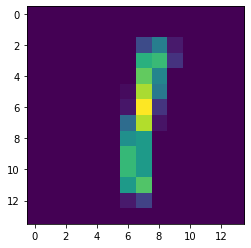

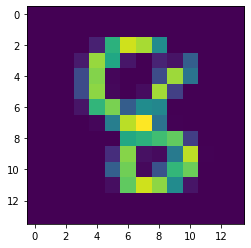

train shape : torch.Size([1000, 2, 14, 14])


In [23]:
plt.imshow( train_input[0][0].numpy() ) 
plt.show()
plt.imshow( train_input[0][1].numpy() ) 
plt.show()
print(f'train shape : {train_input.shape}')

In [24]:
train_dataset = TensorDataset(train_input,train_target , train_classes)
train_dataloader = DataLoader(train_dataset , batch_size=100)

test_dataset = TensorDataset(test_input,test_target , test_classes)
test_dataloader = DataLoader(test_dataset , batch_size=100)


In [25]:
for el in train_dataloader:
  # image , target, classes
  print(el[0].shape, el[1].shape, el[2].shape)
  break

torch.Size([100, 2, 14, 14]) torch.Size([100]) torch.Size([100, 2])


# FullyDenseNN

In [74]:
class FullyDenseNet(nn.Module):
    def __init__(self):
        super(FullyDenseNet, self).__init__()

        self.fc1 = nn.Linear(2*14*14, 300)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 50)
        self.fc5 = nn.Linear(50, 1)

    def forward(self, x):
        x = nn.Flatten(1)(x)
        x = torch.relu( self.fc1(x) )
        x = torch.relu( self.fc2(x) )
        x = torch.relu( self.fc3(x) )
        x = torch.relu( self.fc4(x) )
        x = self.fc5(x)
        return torch.sigmoid(x)

In [75]:
network = FullyDenseNet()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
criterion = F.binary_cross_entropy

In [76]:
def train_epoch(network_):
  loss_tot = []
  network_.train()
  for batch_idx, (data, target , classes ) in enumerate(train_dataloader):
    optimizer.zero_grad()
    output = network_(data).flatten()
    loss = criterion(output, target.to(torch.float32))
    loss.backward()
    optimizer.step()

    loss_tot.append(loss.item())
  
  return torch.FloatTensor(loss_tot).mean().item() , 404

In [77]:
def test(network_):
  network_.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target , classes in test_dataloader:
      output = network_(data)
      test_loss += criterion(output.flatten(), target.to(torch.float32)).item()

  test_loss /= len(test_dataloader)
  return test_loss , 404

In [78]:
def train(network ,epoch_nb = 30,   debug_ = True):

  tot_train_loss = []
  tot_train_acc = []
  tot_test_loss = []
  tot_test_acc = []


  for epoch in range(epoch_nb):
    train_loss , train_acc = train_epoch(network)
    test_loss , test_acc = test(network)

    tot_train_loss.append(train_loss)
    tot_train_acc.append(train_acc)
    tot_test_loss.append(test_loss)
    tot_test_acc.append(test_acc)

    if(debug_):
      print(epoch, train_loss , train_acc , test_loss , test_acc)

  return tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc

In [79]:
tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc = train(network , 30)

0 0.6819345951080322 404 0.581989723443985 404
1 0.4843786656856537 404 0.550797638297081 404
2 0.4227934777736664 404 0.5030846208333969 404
3 0.4060625433921814 404 0.49958708584308625 404
4 0.33892449736595154 404 0.465984246134758 404
5 0.30101364850997925 404 0.461048623919487 404
6 0.2923482060432434 404 0.5118726462125778 404
7 0.24971945583820343 404 0.5643945008516311 404
8 0.17798630893230438 404 0.5451400965452194 404
9 0.12410138547420502 404 0.4996973633766174 404
10 0.0957450121641159 404 0.5050534844398499 404
11 0.11894037574529648 404 0.5392922222614288 404
12 0.0784091055393219 404 0.5406643927097321 404
13 0.04726199060678482 404 0.584421306848526 404
14 0.023893926292657852 404 0.6103017836809158 404
15 0.016913114115595818 404 0.6410122960805893 404
16 0.012336323037743568 404 0.6510552257299423 404
17 0.008795525878667831 404 0.6719117820262909 404
18 0.007182297296822071 404 0.6889796674251556 404
19 0.006113719195127487 404 0.7042015373706818 404
20 0.0053091151

In [80]:
def plot_loss_acc( tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc ):
  epochs = range(1, len(tot_train_loss)+1 )
  plt.plot(epochs, tot_train_loss, 'g', label='Training loss')
  plt.plot(epochs, tot_test_loss, 'b', label='Test loss')
  plt.plot(epochs, tot_train_loss, 'g', label='Training acc')
  plt.plot(epochs, tot_test_loss, 'b', label='Test acc')
  plt.title('Training and Test loss/acc')
  plt.xlabel('Epochs')
  plt.ylabel('loss/acc')
  
  plt.legend()
  plt.show()

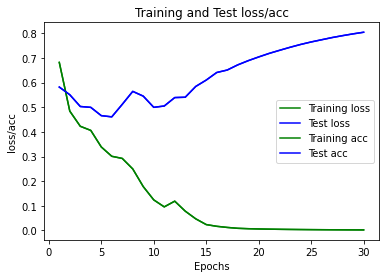

In [81]:
plot_loss_acc( tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc )